# 05. 훈련노하우 배우기
* <font color="red"> 앞에서 구현한 선형회귀/이진분류 알고리즘은 딥러닝 핵심이다. 여기서는 알고리즘이 아닌 이들을 잘 안정적으로 훈련하기위한 노하우, 기법을 배운다. 꼭 알아야 한다.</font>

        5-1. 검증세트와 전처리
        5-2. 과대/과소적합이란
        5-3. 규제방법 공부/적용하기
        5-4. 교차검증 공부/수행

## 5-1. 검증세트와 전처리
<font size =3> "Hyper Parameters" 는 앞에서 설명했듯이 test score를 높이기 위해 튜닝하는 파라미터들이다.<br /> 
**문제는!!** test set에 꼭 맞춤하는 hyper para조합이라는 것이다.<br />
&emsp;&emsp;&emsp; - test외 다른 set에 대한 일반성을 잃은 튜닝을 "test셋 정보가 모델에 새어나감" 이라한다.<br />
&emsp;&emsp;&emsp; - test로 튜닝하지 않아야 한다.(test는 실전 투입전 딱 1번 써야한다.)<br />
&emsp;&emsp;&emsp; - 튜닝용으로는 바로 "**검증셋**"를 사용한다.(train:test:validation=6:2:2)</font>

#### 5-1-1. 검증세트 마련하기
<font size=3><font color='red'> * **훈련:테스트:검증 비율** </font>: <br />
<font color = 'green'>
&emsp;&emsp;&emsp; - 데이터 양이 적으면 나누지 않고 cross validation (교차검증)을 사용한다.<br />
&emsp;&emsp;&emsp; - 요즘 데이터 많다. $10^5$(십만개)는 8:1:1, $10^6$(백만개)는 98:1:1 -훈련세트에 압도적 큰 비율 할당해야함.</font>


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
#1. 데이터 로드 및 나누기 : 훈련:테스트:검증 = 6 : 2 : 2
cancer=load_breast_cancer()
x=cancer.data
y=cancer.target
xT,xs,yT,ys=train_test_split(x,y,stratify=y,test_size=0.2,random_state=42)
xr,xv,yr,yv=train_test_split(xT,yT,stratify=yT,test_size=0.25,random_state=42)
nr=len(yr);ns=len(ys);nv=len(yv);n=nr+ns+nv
print("train:test:validation=",nr,":",ns,":",nv,"=",round(nr/n,1),":",round(ns/n,1),":",round(nv/n,1))
print("False:True = (original data) | (train) | (test) | (validation)")
u=np.unique(y,return_counts=True)[1];print("\t",round(u[0]/sum(u),2),":",round(u[1]/sum(u),2)," | ",end='')
ur=np.unique(yr,return_counts=True)[1];print(round(ur[0]/sum(ur),2),":",round(ur[1]/sum(ur),2)," | ",end='')
us=np.unique(ys,return_counts=True)[1];print(round(us[0]/sum(us),2),":",round(us[1]/sum(us),2)," | ",end='')
uv=np.unique(yv,return_counts=True)[1];print(round(uv[0]/sum(uv),2),":",round(uv[1]/sum(uv),2))
#2. 훈련시키기 (휸련세트이용)
sgd = SGDClassifier(loss='log',random_state=42);sgd.fit(xr,yr)
#3. 평가하기 (검증세트이용)
print("The score is ",round(sgd.score(xv,yv),2))

train:test:validation= 341 : 114 : 114 = 0.6 : 0.2 : 0.2
False:True = (original data) | (train) | (test) | (validation)
	 0.37 : 0.63  | 0.37 : 0.63  | 0.37 : 0.63  | 0.38 : 0.62
The score is  0.9


#### 5-1-2. 전처리
<font color = "green">
&emsp;&emsp;&emsp; - 데이터의 누락등을 배제하는 전처리가 필요하다.<br /> 
&emsp;&emsp;&emsp; - 잘 가공된 데이터라도 스케일 조정이 필요하다.<br /></font>
<font color="cyan">
<br / >
  <그 외 향상> <br ]>
 - 학습률 learning rate : hyperPara, 스텝{w_grad,b_grad} 줄여서 global최적값을 지나치지 않게함.</font> <br />
    
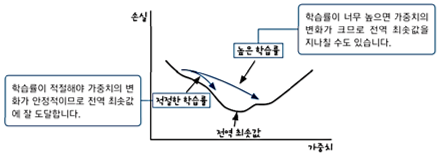

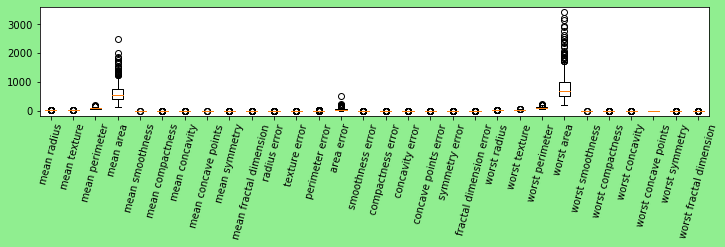

In [2]:
features=cancer.feature_names
fig=plt.figure(figsize=(12,2));fig.patch.set_facecolor("lightgreen")
plt.boxplot(xr);
plt.setp(plt.xticks()[1], rotation=75)
plt.xticks([i for i in range(1,len(features)+1)],features)
plt.show()

<font size=3><font color="red"> 
* **1) 스케일조정 없이 진행** : </font><font color='green'>
&emsp;&emsp;- mean perimeter, mean area의 value는 매우 다른 범위 가졌다. 이를 처리하지 않고 분류 진행해보자.<br />
&emsp;&emsp;- 스케일링 필요성이 어디서 요구되는지 알아보자.

<ipython-input-3-088a5f83eef6>:7: RuntimeWarning: overflow encountered in exp
  def activation(self,z):return 1/(1+np.exp(-z))


Score unscaled= 0.85


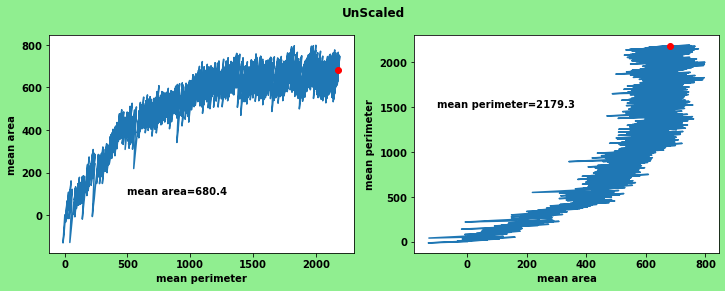

In [3]:
class Layer_Single:
    def __init__(self,learning_rate=0.1):
        self.w=None;self.b=None;
        self.losses=[];self.w_history=[]
        self.lr=learning_rate
    def forpass(self,x):return np.sum(x*self.w)+self.b
    def activation(self,z):return 1/(1+np.exp(-z))
    def backprop(self,x,err):return -x*err,-1*err
    def loss(self,y,a):return -y*np.log(a)-(1-y)*np.log(1-a)
    def fit(self,x,y,epochs=100):
        xlen=np.shape(x)[0];xcol=np.shape(x)[1];
        self.w=np.ones(xcol);self.b=0
        for epoch in range(0,epochs):
            idx=np.random.permutation(np.arange(xlen));loss_per_epoch=0
            for i in idx:
                self.w_history.append(self.w.copy());z=self.forpass(x[i])
                a=self.activation(z);err=y[i]-a;w_grad,b_grad=self.backprop(x[i],err)
                self.w-=w_grad*self.lr;self.b-=b_grad
                a=np.clip(a,1e-10,1-1e-10);loss_per_epoch+=self.loss(y[i],a)
            self.losses.append(loss_per_epoch/xlen)
    def predict(self,x):
        z=np.array([self.forpass(xi) for xi in x]);a=self.activation(z)
        return a>0.5
    def score(self,x,y):return np.mean(self.predict(x)==y)
#apply
layer=Layer_Single();layer.fit(xr,yr);print("Score unscaled=",round(layer.score(xv,yv),2))
w=np.array(layer.w_history);w2 = w[:,2];w3 = w[:,3]
fig=plt.figure(figsize=(12,4));fig.patch.set_facecolor("lightgreen")
plt.rcParams["font.weight"] = "bold";plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["figure.titleweight"] = "bold";
fig.suptitle("UnScaled")
p1=plt.subplot(1,2,1);p1.plot(w2,w3);p1.set_xlabel(features[2]);p1.set_ylabel(features[3]);
p1.text(500,100,'mean area=%.1f'%w3[-1])
p1.plot(w2[-1],w3[-1],'ro')
p2=plt.subplot(1,2,2);p2.plot(w3,w2);p2.set_xlabel(features[3]);p2.set_ylabel(features[2]);
p2.text(-100,1500,'mean perimeter=%.1f'%w2[-1])
p2.plot(w3[-1],w2[-1],'ro')
plt.show()

<font size=3><font color="cyan">
- mean area의 x가 더 100~1000사이의 큰 폭 통계를 가진다. mean perimeter는 수100정도에 밀집해있고. <br />
- mean perimeter의 w[2]는 0부터 시작하여 최적값(~2100)에 가까워진다.<br />
- mean area의 w[3]는 역시 0부터 시작하나, 최적값(~500)에 가는 동안 크게 요동친다. <br /></font>
<font color ='lightblue'>**스케일이 큰 x범위의 feature는 {w,b}에 불안정하게 수렴하는 것 확인!! 스케일링 필요한 이유이다.** 


<font size=3><font color="red"> 
* **2) 스케일조정 해서 진행** : </font><font color='green'>
&emsp;&emsp;- 위에서 스케일이 큰 x값을 가진 feature의 {w,b}가 더 불안정한 수렴을 보였다.<br />
&emsp;&emsp;- 이를 안정적으로 수렴시키기 위해서 x값들을 <font color='red'>**"표준화 (Standardization)"**</font>시킨다.<br />
&emsp;&emsp;- 훈련/테스트/검증데이터셋을 모두 "훈련"의 통계값으로 동일하게 스케일링 해야한다.<br />
&emsp;&emsp;&emsp;&emsp;zr/zs/zv$=\dfrac{x-\mu}{s}$ where $\mu=\dfrac{1}{nr}\sum{xr[i]}$ and $s=\sqrt{\dfrac{1}{nr}\sum{(xr[i]-\mu)^2}}$<br />
<font color='cyan'>* sklearn 에도 표준화위한 "StandardScalar"클래스가 있지만 여기선 직접코딩한다. 

score with validation set = 0.9649122807017544
score with     test   set = 0.9736842105263158


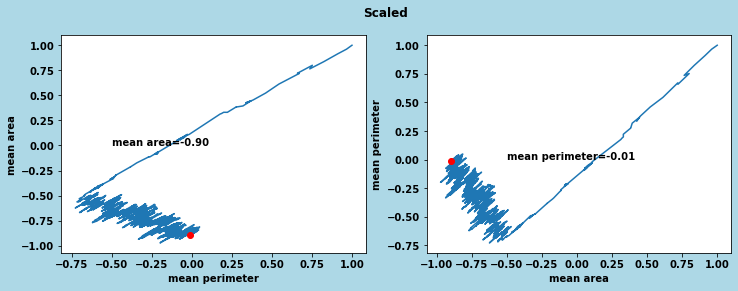

In [5]:
mu=np.mean(xr,axis=0);s=np.std(xr,axis=0)
zr=(xr-mu)/s;zs=(xs-mu)/s;zv=(xv-mu)/s;
layer_scaled=Layer_Single();layer_scaled.fit(zr,yr)
w_scaled=np.array(layer_scaled.w_history);w2_scaled=w_scaled[:,2];w3_scaled=w_scaled[:,3]
fig=plt.figure(figsize=(12,4));fig.patch.set_facecolor("lightblue")
plt.rcParams["font.weight"]="bold"; plt.rcParams["axes.labelweight"]="bold"
plt.rcParams["figure.titleweight"]="bold"
fig.suptitle("Scaled")
p1=plt.subplot(1,2,1);p1.plot(w2_scaled,w3_scaled);p1.set_xlabel(features[2]);p1.set_ylabel(features[3])
p1.text(-0.5,0,'mean area=%.2f'%w3_scaled[-1])
p1.plot(w2_scaled[-1],w3_scaled[-1],'ro');
p2=plt.subplot(1,2,2);p2.plot(w3_scaled,w2_scaled);p2.set_xlabel(features[3]);p2.set_ylabel(features[2])
#p2.text(-0.5,0,'mean perimeter=');p2.text(0.3,0,round(w2_scaled[-1],2))
p2.text(-0.5,0,'mean perimeter=%.2f'%w2_scaled[-1])
p2.plot(w3_scaled[-1],w2_scaled[-1],'ro');
print ("score with validation set =",layer_scaled.score(zv,yv))
print ("score with     test   set =",layer_scaled.score(zs,ys))

<font size=3><font color="cyan"> 
- 이제 mean perimeter, mean area를 스케일링하여 w의 수렴정도가 비슷한 경향을 보이는 것을 확인하였다. <br />
- 그럼 여기서 score올리기 위한 본격 parameter조정 들가는 것일까?<br />
- 뭘하던 validation세트(검증셋)를 이용하여야 하며, test경우는 마지막에 한번사용하는 것이좋다.
    

## 5-2. 과대/과소적합이란?
<font size =3> 
앞서 보였듯, 일반화 유지를 위해 테스트셋은 맨 나중으로 보류하고 검증셋을 이용해야 한다.<br />
본격적으로 검증셋의 score를 높이는 방향으로 모델수정하기에 앞서, x값의 표준화를 거쳤다.<br /> 
(여기서 통계파라미터는 훈련셋의 평균/표준편차로 통일해야한다.) <br />
&emsp;&emsp;이제 준비가 된 것인가?<br />
&emsp;**훈련/검증셋-성능**의 <font color='yellow'>"훈련셋크기/학습횟수/모델복잡도(층수)"</font> 따른 경향으로부터 향상방법 파악가능. <br />
<font color="red">
* **과대/과소적합 (Over/Under-fitting)** : <br />
&emsp;&emsp;&emsp;&emsp;과대적합 : 훈련/검증차이 크고 (high Variance) 훈련만 잘 맞음<br /> 
&emsp;&emsp;&emsp;&emsp;과소적합 : 훈련/검증차이 작고 &emsp;&emsp;&emsp;&ensp;&ensp;&emsp;&ensp;&emsp;둘 다 안맞는(high Bias)<br /></font>

#### 5-2-2. Learning Curve (학습곡선)에서의 과대/과소적합
    
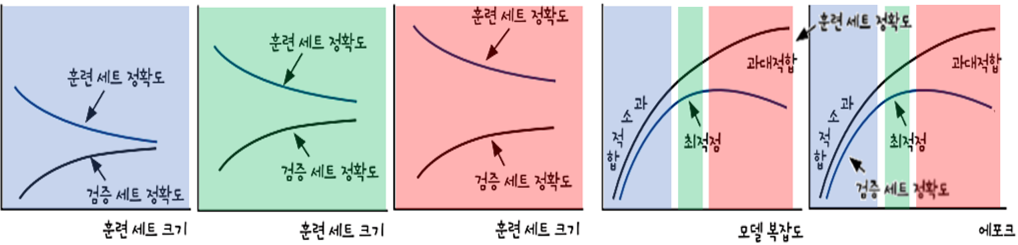
    
| | 과대적합 | 과소적합 | 절충   |
|:---------------------|:----------------------------|:----------------------------|:----------------------------|
|특징| High Variance | High Bias | Neither |
|원인|* 다양성 적은 훈련셋으로 학습한 모델은 성능이 낮다.<br />* 학습횟수 과하면 훈련셋용 꼭맞춤되어 일반성 잃음.<br />* layer수 많을수록 역시 훈련셋용 꼭맞춤된다.|* layer적은 모델은 훈련셋의 다양성 못배움.<br />* 학습횟수 적으면 훈련셋 자체를 못배움.<br />* layer수 적으면 역시 훈련셋 학습불가. | 과대/과소적합 사이의 절충점 찾은 모습|
|해결|* 다양한 훈련데이터 확보<br/> * 복잡도 감소:모델이 훈련세트에 집착않게 {w,b} 규제 | * 다양한성 큰 모델 사용<br/> * 복잡도 증가:{w,b} 규제완화 |  |  

#### 5-2-3. 이제 과대/과소 고려한 성능향상 구현해보자
over/under-fitting에 따라 성능향상하도록 <font color='yellow'>"훈련셋크기/학습횟수/모델복잡도(층수)"</font>을 조절하면 된다. <br />이러한 과정을 최적으로 <font color='yellow'>"적절한 Bias-Variance Tradeoff를 찾았다" </font>라고 한다.<br /></font>
그런데 지금은 훈련셋/모델복잡도(singlr-layer)는 못바꾸니까 epoch조절을 통해 optimal 찾아보자.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
class Layer_Single:
    def __init__(self,learning_rate=0.1):
        self.w=None;self.b=None;
        self.w_history=[];
        self.losses=[];self.losses_val=[]
        self.lr=learning_late
    def forpass(self,x):return np.sum(self.w*x)+b
    def activation(self,z):return 1/(1+np.exp(-z))
    def backprop(self,x,err):return -x*err,-1*err
    def losses(self,a,y):return -y*np.log(a)-(1-y)np.log(1-a)
    def fit(self,x,y,epochs=100):
        xlen=np.shape(x)[0];xcol=np.shape(x)[1]
        self.w=np.ones(xcol);self.b=np.zeros(xcol)
        self.w_history.append(self.w.copy())
        np.random.seed(42)#for comparison
        for epoch in range (0,epochs):
            idx = np.random.permutation(xlen);loss_per_epoch=0
            for i in range(0,xlen):
                
                z=self.forpass(x[i]);a=self.activation(z);err=y[i]-a
                w_grad,b_grad=self.backprop(x,err)
                self.w-=w_grad;self.b-=b_grad
                loss_per_epoch+=self.losses(a,y[i])
            self.losses.append(loss_per_epoch/xlen)
    
                
                
        
